<a href="https://colab.research.google.com/github/aiaaee/Policy-Improvement-Methods-Analysis/blob/main/Policy_improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
!pip install gym==0.13.1

In [97]:
import numpy as np
import warnings ; warnings.filterwarnings('ignore')
import sys
# import gymnasium as gym
import matplotlib.pyplot as plt
import gym

## N-chain RL

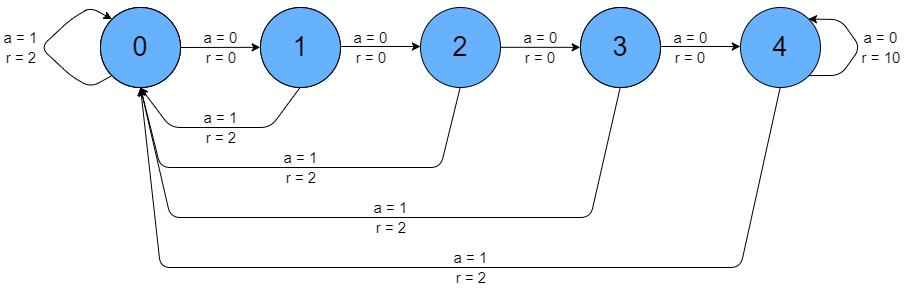

In [98]:
env = gym.make("NChain-v0", n=5, slip=0.2, small=2, large=10)

In [99]:
print('Number of actions:' , env.action_space.n)
print('Number of States: ' , env.observation_space.n)

Number of actions: 2
Number of States:  5


In [100]:
def epsilon_greedy(env , epsilon=0.1 , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    if np.random.rand() < epsilon :
      action = env.action_space.sample()
    else :
      action = np.argmax(Q[state])

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) , Q

In [101]:
state = env.reset()
next_state , reward , done , truncated = env.step(0)

In [102]:
def pure_exploitation(env , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    action = np.argmax(Q[state])

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) ,  Q



In [103]:
def pure_exploration(env , n_episodes=100):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  returns = []
  state = env.reset()

  for ep in range(n_episodes):
    action = env.action_space.sample()

    next_state , reward , terminated , truncated = env.step(action)
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])
    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()
  return np.array(returns) ,  Q

In [104]:
def softmax(env, init_temp=1.0, min_temp=0.01,
            decay_rate=0.995, n_episodes=1000 , alpha=0.1 , gamma=0.99 ):
    n_actions = env.action_space.n
    n_states = env.observation_space.n
    Q = np.zeros((n_states, n_actions))
    returns = []
    state = env.reset()
    temp = init_temp
    for e in range(n_episodes):
        temp = max(min_temp, temp * decay_rate)
        logits = Q[state] / temp
        logits -= np.max(logits)
        probs = np.exp(logits) / np.sum(np.exp(logits))
        action = np.random.choice(n_actions, p=probs)
        next_state, reward, terminated, truncated = env.step(action)
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
        returns.append(reward)
        if terminated or truncated:
            state = env.reset()
        else:
            state = next_state

    return np.array(returns), Q


In [105]:
def upper_confidence_bound(env , C=2 , n_episodes=1000 ):
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states , n_actions))
  N = np.zeros((n_states , n_actions))

  returns = []
  state = env.reset()
  for e in range(n_states):
    U = np.zeros(n_actions)
    for a in range(n_actions):
      if N[state , a ] == 0 :
        U[a] = np.inf
      else :
        U[a] = C * np.sqrt(np.log(e + 1 ) / N[state , a])
    action = np.argmax(Q[state] + U)
    next_state , reward , terminated , truncated = env.step(action)

    N[state , action] += 1
    Q[state , action] = Q[state , action] + 0.1 * (reward - Q[state , action])

    returns.append(reward)
    state = next_state

    if terminated or truncated :
      state = env.reset()

  return np.array(returns ) , Q

In [106]:
def thompson(env , n_episodes=1000):
  n_actions = env.action_space.n
  n_states = env.observation_space.n

  alpha = np.ones((n_states , n_actions))
  beta = np.ones((n_states , n_actions))

  returns = []
  state = env.reset()

  for eps in range(n_episodes):
    sample = np.zeros(n_actions)
    for a in range(n_actions):
      sample[a] = np.random.beta(alpha[state , a ] , beta[state , a])
    action = np.argmax(sample)

    next_state , reward , terminated , truncated = env.step(action)

    if reward == 1 :
      alpha[state , action] += 1
    else :
      beta[state , action] += 1

    returns.append(reward)
    state = next_state

    if truncated or terminated :
      state = env.reset()
  return np.array(returns) , alpha , beta

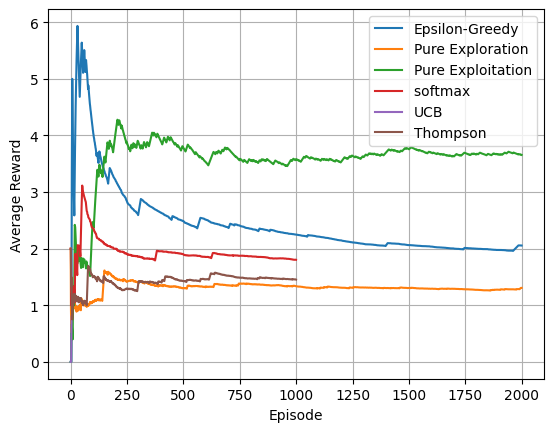

In [107]:
returns_eps, _ = epsilon_greedy(env, epsilon=0.1, n_episodes=2000)
returns_explore , _ = pure_exploration(env , n_episodes=2000)
returns_exploit , _ = pure_exploitation(env , n_episodes=2000)
returns_softmax , _ = softmax(env , init_temp=1.0, min_temp=0.01, decay_rate=0.995, n_episodes=1000 , alpha=0.1 , gamma=0.99 )
returns_ucb , _ = upper_confidence_bound(env , C=2 , n_episodes=2000)
returns_thompson , _ , _ = thompson(env)


epsilon_avg_rewards = np.cumsum(returns_eps) / (np.arange(len(returns_eps)) + 1)
explore_avg_rewards = np.cumsum(returns_explore) / (np.arange(len(returns_explore)) + 1)
exploit_avg_rewards = np.cumsum(returns_exploit) / (np.arange(len(returns_exploit)) + 1)
softmax_avg_rewards = np.cumsum(returns_softmax) / (np.arange(len(returns_softmax)) + 1)
ucb_avg_rewards = np.cumsum(returns_ucb) / (np.arange(len(returns_ucb)) + 1)
thompson_avg_rewards = np.cumsum(returns_thompson) / (np.arange(len(returns_thompson)) + 1)


plt.plot(epsilon_avg_rewards, label="Epsilon-Greedy")
plt.plot(explore_avg_rewards, label="Pure Exploration")
plt.plot(exploit_avg_rewards, label="Pure Exploitation")
plt.plot(softmax_avg_rewards, label="softmax ")
plt.plot(ucb_avg_rewards , label="UCB")
plt.plot(thompson_avg_rewards , label="Thompson")

plt.plot()
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend()
plt.grid(True)
plt.show()